# Natural Language Processing with Disaster Tweets
Xây dựng một mô hình máy học dự đoán Tweet nào nói về thảm họa thực sự và Tweet nào không.

## Người thực hiện
20120540- Võ Hoàng Thảo Nguyên

## Khám phá và tiền xử lý dữ liệu

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import data_processing as mylib

In [2]:
df_train = pd.read_csv("./dataset/train.csv")
df_test=pd.read_csv("./dataset/test.csv")

In [3]:
print("Train Data points count: ", df_train['id'].count())
print(df_train.isna().sum())
df_train.tail()

Train Data points count:  7613
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [4]:
print("Test Data points count: ", df_test['id'].count())
print(df_test.isna().sum())
df_test.tail()

Test Data points count:  3263
id             0
keyword       26
location    1105
text           0
dtype: int64


,id,keyword,location,text
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...


Ta sẽ drop cột `location` sau và fillna cột `keyword` bằng 'no_keyword'.

In [5]:
mylib.handle_missing_values(df_train)
df_train.isna().sum()

id             0
keyword        0
location    2533
text           0
target         0
dtype: int64

## Phân phối nhãn của dữ liệu

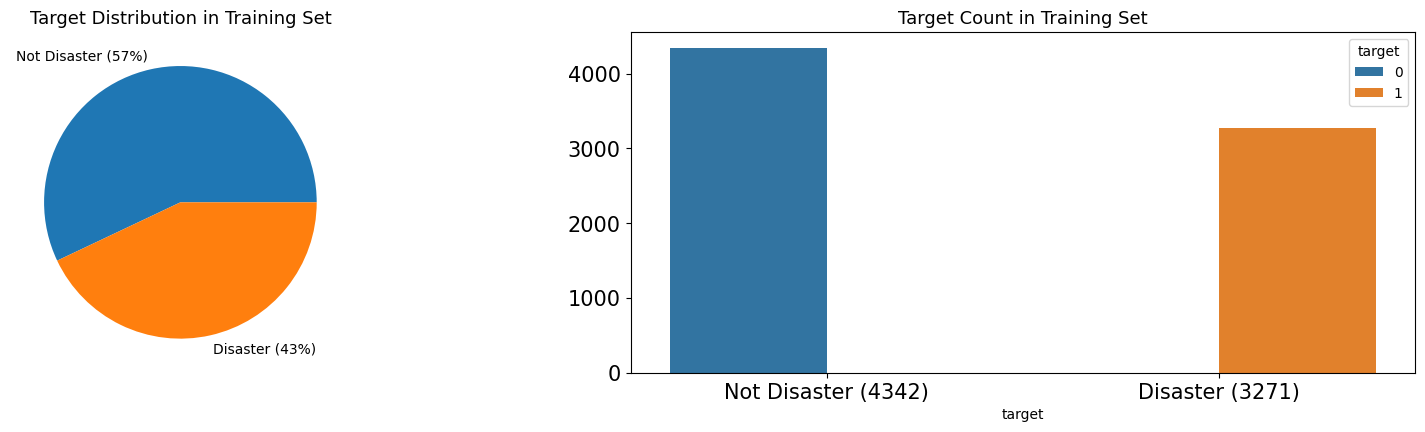

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df_train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=df_train['target'], hue=df_train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

## Kiểm tra phân phối số lượng từ trong 1 câu tweet

C:\Users\St3phen\AppData\Local\Temp\ipykernel_2104\416846640.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['word_count'].values, hist=True, kde=True, kde_kws={"shade": True})
c:\Users\St3phen\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


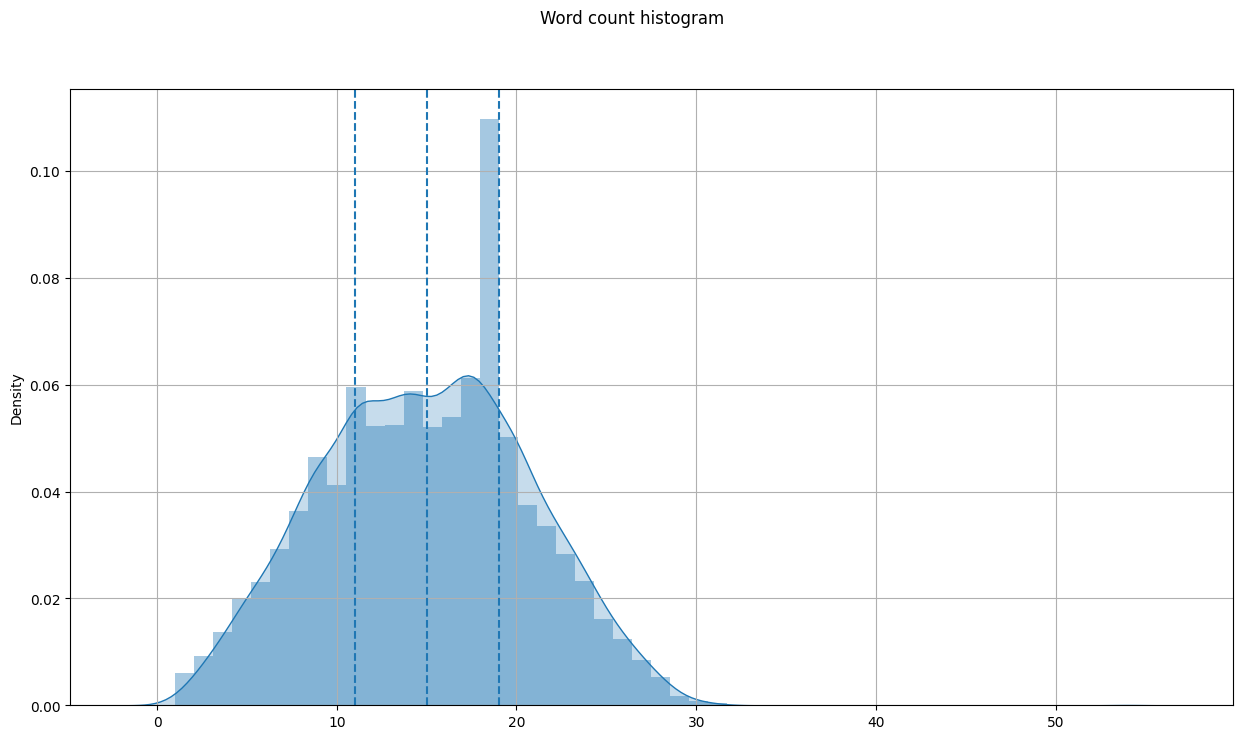

In [7]:
df_train['word_count'] = df_train['text'].apply(lambda x: len(x.split(" ")) )

plt.figure(figsize=(15,8))
sns.distplot(df_train['word_count'].values, hist=True, kde=True, kde_kws={"shade": True})
plt.axvline(df_train['word_count'].describe()['25%'], ls="--")
plt.axvline(df_train['word_count'].describe()['50%'], ls="--")
plt.axvline(df_train['word_count'].describe()['75%'], ls="--")

plt.grid()
plt.suptitle("Word count histogram")
plt.show()


In [8]:
from collections import defaultdict
from wordcloud import STOPWORDS
DISASTER_TWEETS=df_train.target==1
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 50

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

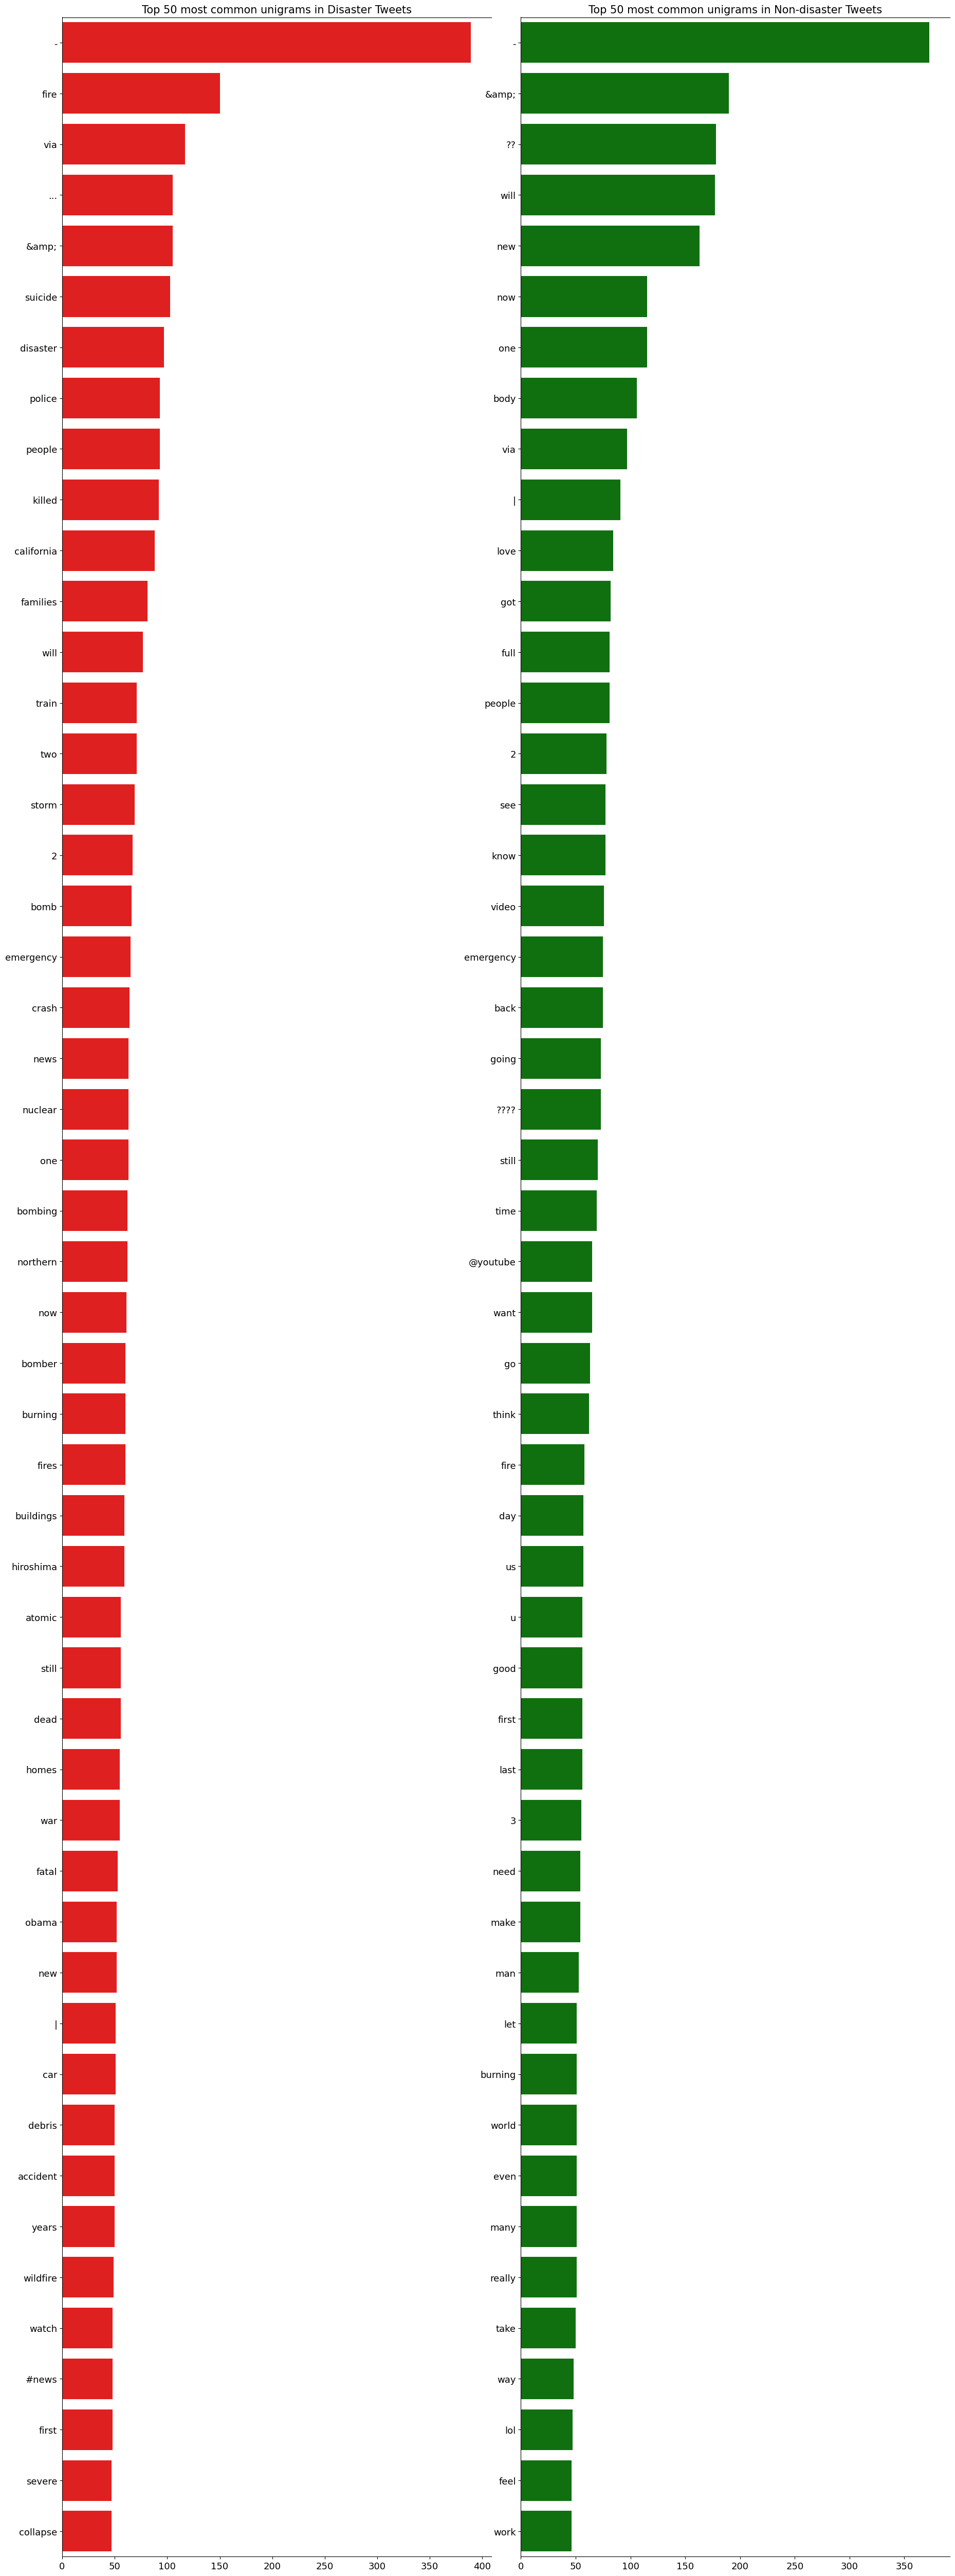

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

C:\Users\St3phen\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


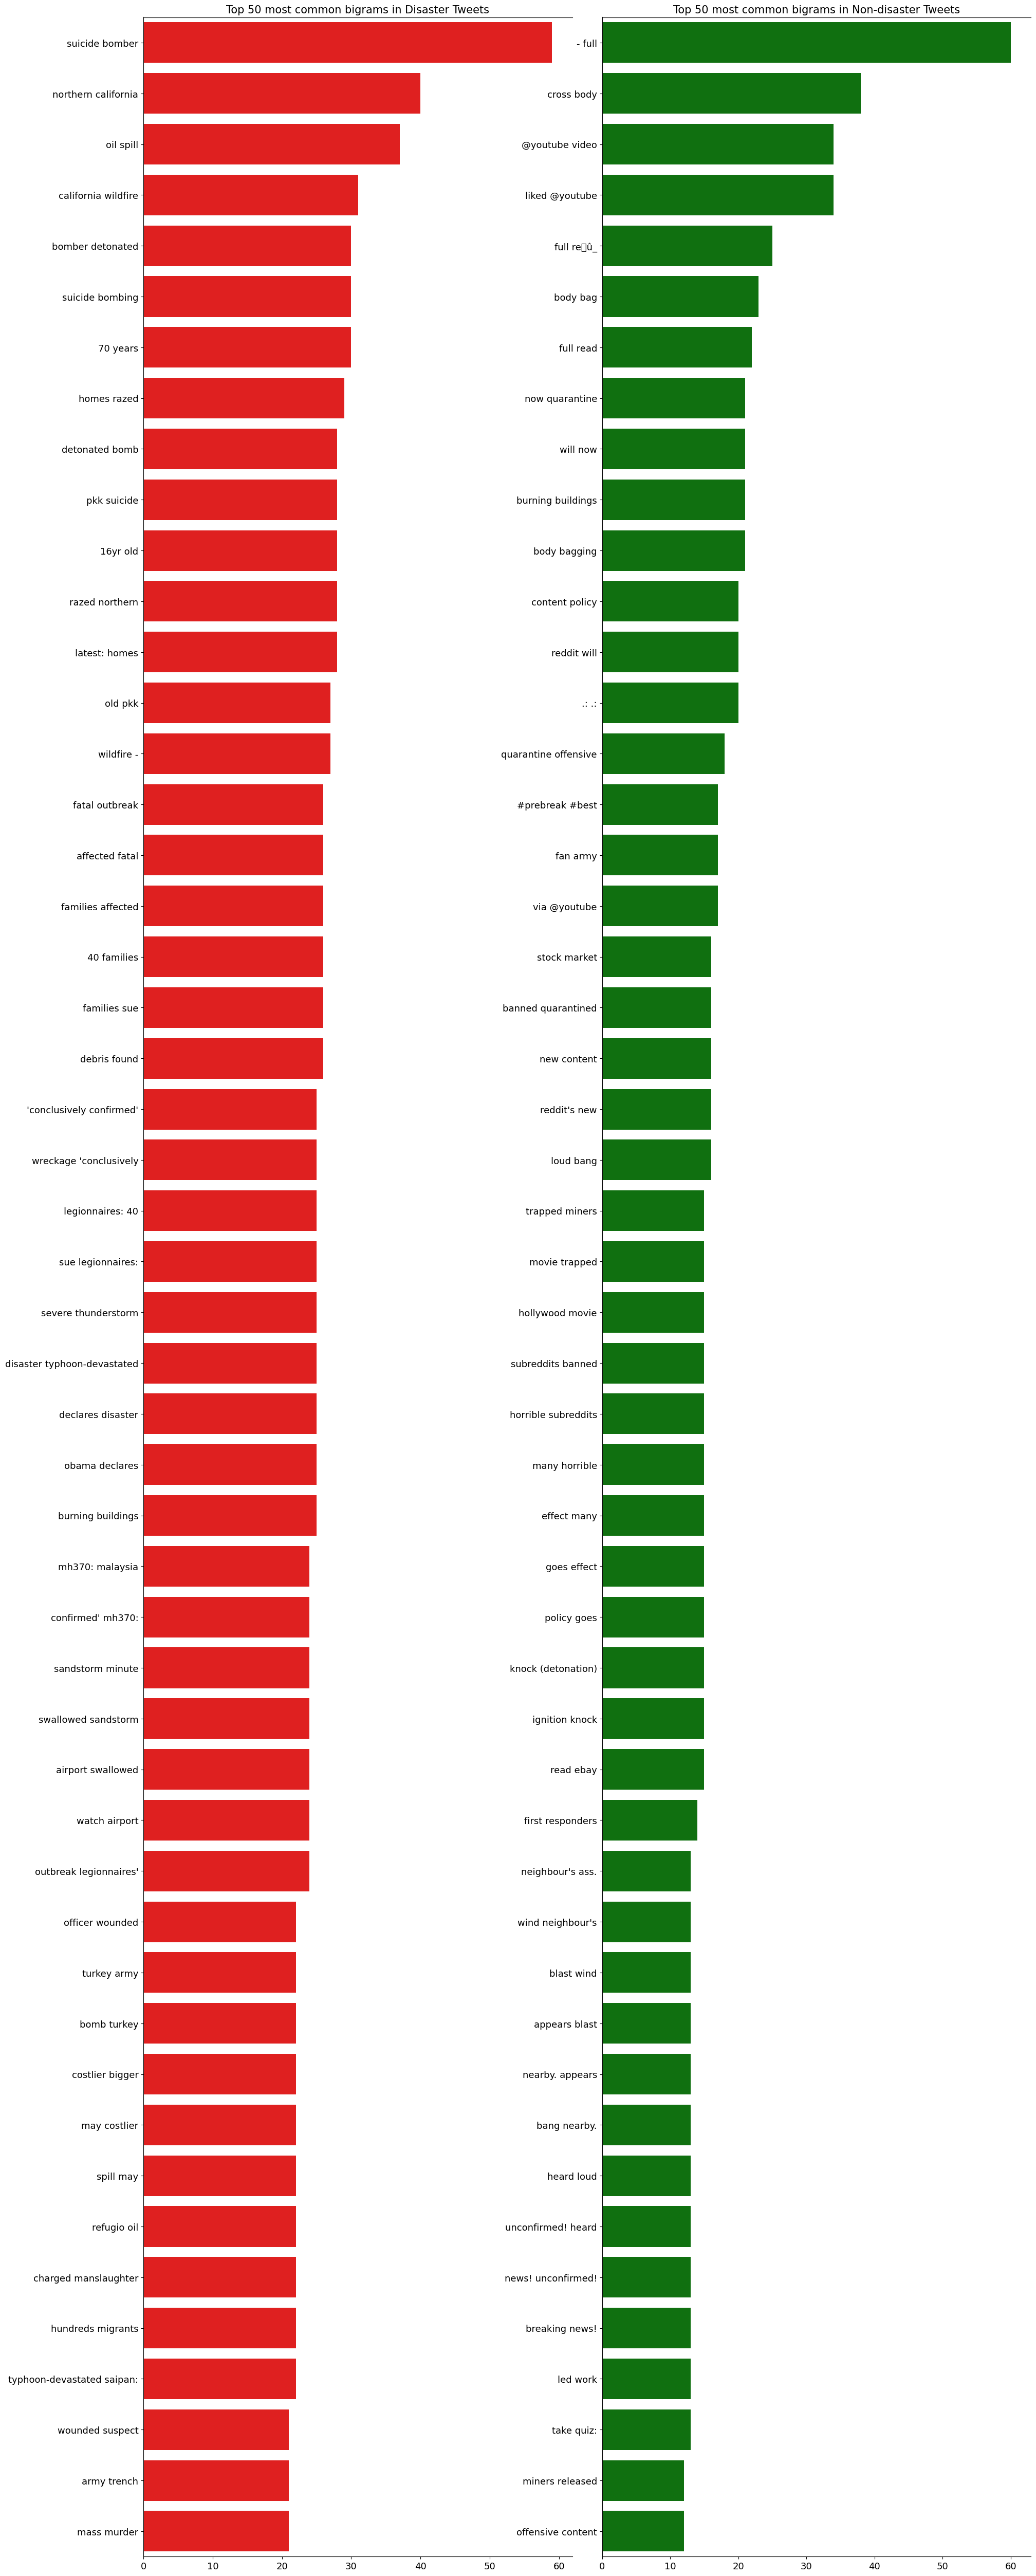

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

### Kiểm tra các dữ liệu bị sai nhãn

In [11]:
print(f"Duplicate tweet: {df_train[df_train.duplicated(subset=['text'])].sort_values('text').shape[0]}")
df_train[df_train.duplicated(subset=['text'])].sort_values('text').tail()

Duplicate tweet: 110


,id,keyword,location,text,target,word_count
3461,4952,exploded,NaN,that exploded &amp; brought about the\nbeginni...,0,18
6103,8714,sinking,NaN,that horrible sinking feeling when youÛªve be...,0,25
6094,8702,sinking,NaN,that horrible sinking feeling when youÛªve be...,0,25
6123,8739,sinking,MA,that horrible sinking feeling when youÛªve be...,1,25
5641,8044,refugees,NaN,wowo--=== 12000 Nigerian refugees repatriated ...,0,7


In [12]:
df_mislabeled = df_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
print(len(df_mislabeled.index))


18


### Xử lý các dữ liệu bị sai nhãn

Ta thấy có 18 bộ `text` riêng biệt có cả nhãn 1 và 0 cho cùng 1 nội dung. Có thể nhầm lẫn đã xảy ra trong gia đoạn gắng nhãn. vì có 18 bộ nên ta tự đọc và chọn lại nhãn chính xác cho chúng.

In [13]:
df_train.loc[df_train['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target'] = 0
df_train.loc[df_train['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target'] = 0
df_train.loc[df_train['text'] == 'To fight bioterrorism sir.', 'target'] = 0
df_train.loc[df_train['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target'] = 1
df_train.loc[df_train['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target'] = 1
df_train.loc[df_train['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target'] = 0
df_train.loc[df_train['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target'] = 0
df_train.loc[df_train['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target'] = 1
df_train.loc[df_train['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target'] = 1
df_train.loc[df_train['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target'] = 0
df_train.loc[df_train['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target'] = 0
df_train.loc[df_train['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target'] = 0
df_train.loc[df_train['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target'] = 0
df_train.loc[df_train['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target'] = 0
df_train.loc[df_train['text'] == "Caution: breathing may be hazardous to your health.", 'target'] = 1
df_train.loc[df_train['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target'] = 0
df_train.loc[df_train['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target'] = 0
df_train.loc[df_train['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target'] = 0

In [14]:
df_mislabeled = df_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
len(df_mislabeled.index)


0

Xữ lý duplicate.

In [15]:
print(f"Duplicate tweet before: {df_train[df_train.duplicated(subset=['text'])].sort_values('text').shape[0]}")
df_train=df_train.drop_duplicates(subset=['text'],keep='last')
print(f"Duplicate tweet after: {df_train[df_train.duplicated(subset=['text'])].sort_values('text').shape[0]}")

Duplicate tweet before: 110
Duplicate tweet after: 0


## Xử lý cột keyword

In [16]:
kw=df_train['keyword'].unique()
print(len(kw))
print(kw[:20])

222
['no_keyword' 'ablaze' 'accident' 'aftershock' 'airplane%20accident'
 'ambulance' 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army'
 'arson' 'arsonist' 'attack' 'attacked' 'avalanche' 'battle' 'bioterror'
 'bioterrorism' 'blaze']


In [17]:
df_train["keyword_cleaned"]=df_train['keyword'].apply(mylib.handle_keyword)
kw=df_train["keyword_cleaned"].unique()
print(len(kw))
print(kw[:20])

212
['no_keyword' 'ablaze' 'accident' 'aftershock' 'airplane accident'
 'ambulance' 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army'
 'arson' 'arsonist' 'attack' 'attacked' 'avalanche' 'battle' 'bioterror'
 'bioterrorism' 'blaze']


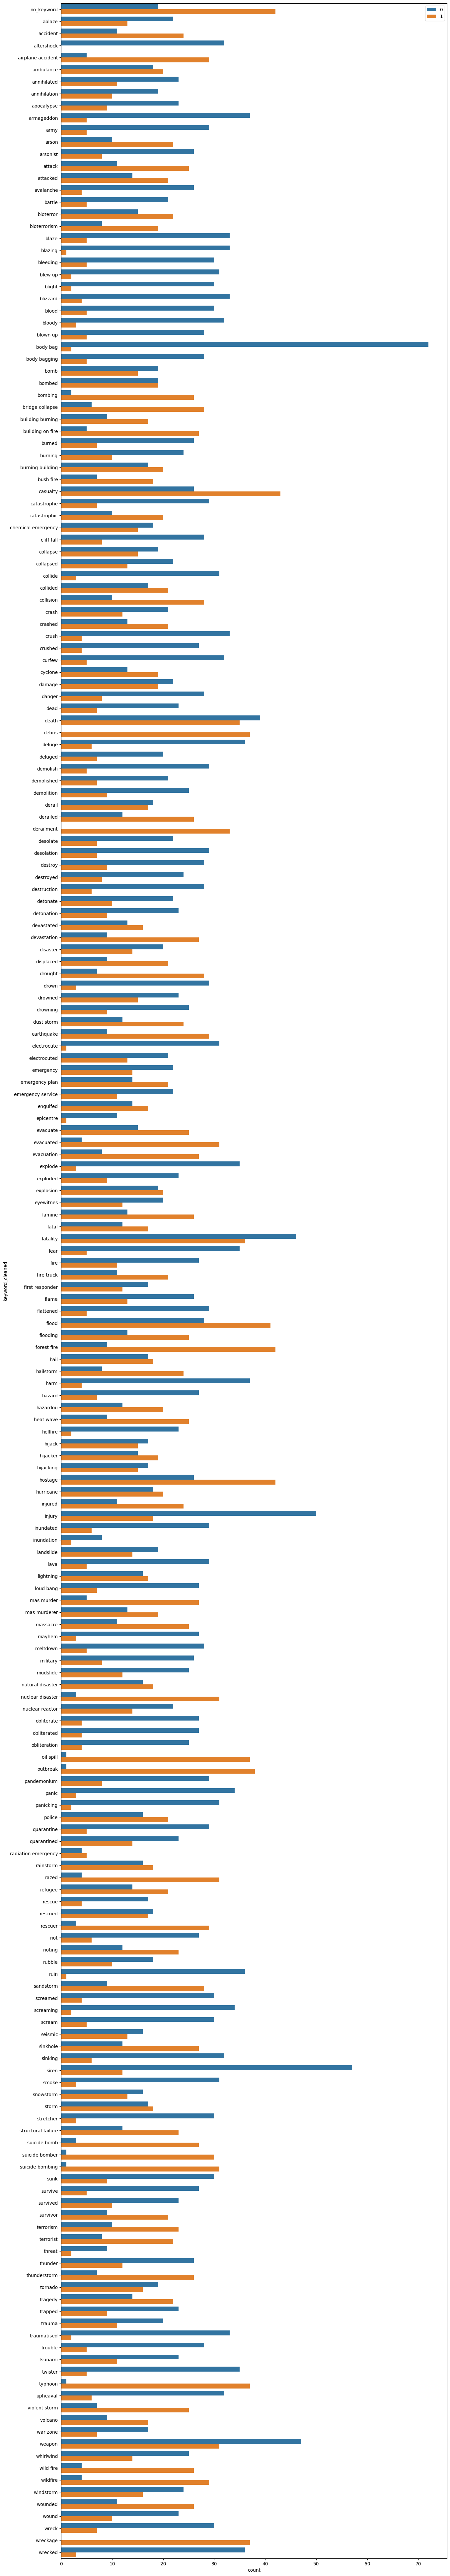

In [18]:
plt.figure(figsize=(15,100))
sns.countplot(data=df_train, y='keyword_cleaned', hue='target')
plt.legend()

In [19]:
# df_train=mylib.add_count_features(df_train)
# df_train = df_train[df_train['word_count']>2]
# df_train.tail()

## Xử lý text

In [20]:
df_train["text_cleaned"] = df_train["text"].apply(mylib.process_content)
df_train.head()

c:\Source\data_analytics\pj\src\data_processing.py:287: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text,features="html.parser")


,id,keyword,location,text,target,word_count,keyword_cleaned,text_cleaned
0,1,no_keyword,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,no_keyword,deed reason earthquake may allah forgive
1,4,no_keyword,NaN,Forest fire near La Ronge Sask. Canada,1,7,no_keyword,forest fire near la range sask canada
2,5,no_keyword,NaN,All residents asked to 'shelter in place' are ...,1,22,no_keyword,resident asked shelter place notified officers...
3,6,no_keyword,NaN,"13,000 people receive #wildfires evacuation or...",1,9,no_keyword,people receive wildfire evacuation order calif...
4,7,no_keyword,NaN,Just got sent this photo from Ruby #Alaska as ...,1,17,no_keyword,got sent photo ruby alaska smoke wildfire pour...


In [21]:
duplicated=df_train[df_train.duplicated(subset=["text_cleaned"])]["text_cleaned"].sort_values()
print(df_train.shape[0])
print(len(duplicated))
print(duplicated)

7503
676
4556    adam terror attack militant attack police post...
4561    adam terror attack militant attack police post...
1425    afghanistan sharp rise woman child casualty fi...
131                                        aftershock url
2168    aircraft debris found la reunion missing malay...
                              ...                        
2767    year atomic bomb japan still struggle war past...
2762    year atomic bomb japan still struggle war past...
2757    year atomic bomb japan still struggle war past...
2753    year atomic bomb japan still struggle war past...
2775    year atomic bomb japan still struggle war past...
Name: text_cleaned, Length: 676, dtype: object


In [22]:
df_train.drop_duplicates("text_cleaned",keep='last',inplace=True)
print(df_train.shape[0])

6827


Xử lý tập test tương tự ngoại trừ những xử lý liên quan đến drop dòng

In [23]:
print("Test Data points count: ", df_test['id'].count())
print(df_test.isna().sum())
df_test.tail()

Test Data points count:  3263
id             0
keyword       26
location    1105
text           0
dtype: int64


,id,keyword,location,text
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...


In [24]:
mylib.handle_missing_values(df_test)
df_test["keyword_cleaned"]=df_test['keyword'].apply(mylib.handle_keyword)
# df_test=mylib.add_count_features(df_test)
df_test["text_cleaned"] = df_test["text"].apply(mylib.process_content)
df_test.isna().sum()

c:\Source\data_analytics\pj\src\data_processing.py:287: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text,features="html.parser")


id                    0
keyword               0
location           1105
text                  0
keyword_cleaned       0
text_cleaned          0
dtype: int64

In [25]:
df_test[df_test["id"]==43]

,id,keyword,location,text,keyword_cleaned,text_cleaned
13,43,no_keyword,NaN,What if?!,no_keyword,


In [26]:
df_test.loc[df_test["id"]==43, "text_cleaned"] = "what if"
df_test[df_test["id"]==43]

,id,keyword,location,text,keyword_cleaned,text_cleaned
13,43,no_keyword,NaN,What if?!,no_keyword,what if


In [27]:
df_train

,id,keyword,location,text,target,word_count,keyword_cleaned,text_cleaned
0,1,no_keyword,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,no_keyword,deed reason earthquake may allah forgive
1,4,no_keyword,NaN,Forest fire near La Ronge Sask. Canada,1,7,no_keyword,forest fire near la range sask canada
2,5,no_keyword,NaN,All residents asked to 'shelter in place' are ...,1,22,no_keyword,resident asked shelter place notified officers...
3,6,no_keyword,NaN,"13,000 people receive #wildfires evacuation or...",1,9,no_keyword,people receive wildfire evacuation order calif...
4,7,no_keyword,NaN,Just got sent this photo from Ruby #Alaska as ...,1,17,no_keyword,got sent photo ruby alaska smoke wildfire pour...
...,...,...,...,...,...,...,...,...
7608,10869,no_keyword,NaN,Two giant cranes holding a bridge collapse int...,1,11,no_keyword,two giant crane holding bridge collapse nearby...
7609,10870,no_keyword,NaN,@aria_ahrary @TheTawniest The out of control w...,1,20,no_keyword,tweetermention tweetermention control wild fir...
7610,10871,no_keyword,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8,no_keyword,etc pm volcano hawaii url
7611,10872,no_keyword,NaN,Police investigating after an e-bike collided ...,1,19,no_keyword,police investigating bike collided car little ...


0    4052
1    2775
Name: target, dtype: int64

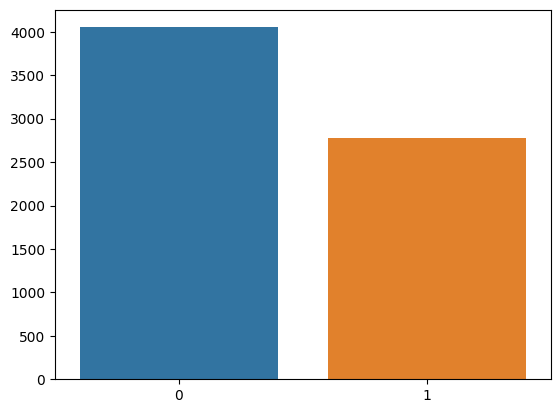

In [28]:
value_counts = df_train['target'].value_counts()
sns.barplot(x=value_counts.index, y=value_counts.values)
df_train['target'].value_counts()

C:\Users\St3phen\AppData\Local\Temp\ipykernel_2104\1894932151.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['word_count'].values, hist=True, kde=True, kde_kws={"shade": True})
c:\Users\St3phen\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


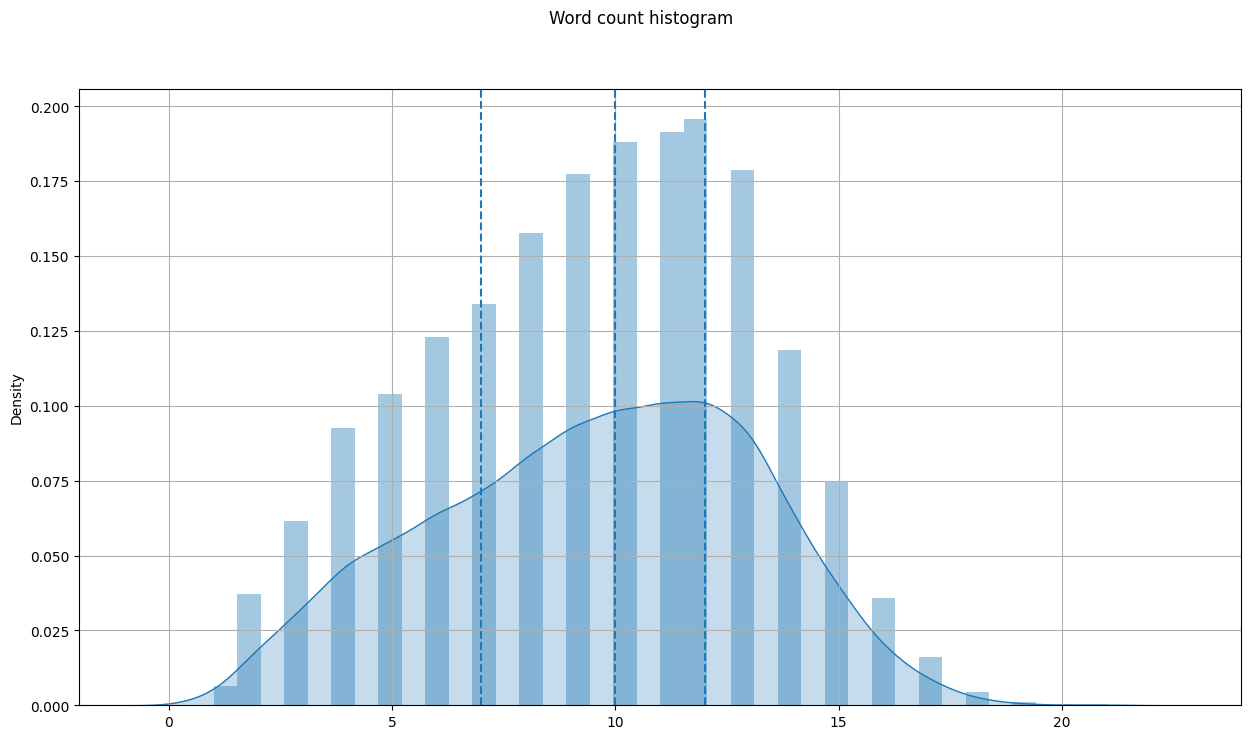

In [29]:
df_train['word_count'] = df_train['text_cleaned'].apply(lambda x: len(x.split(" ")) )

plt.figure(figsize=(15,8))
sns.distplot(df_train['word_count'].values, hist=True, kde=True, kde_kws={"shade": True})
plt.axvline(df_train['word_count'].describe()['25%'], ls="--")
plt.axvline(df_train['word_count'].describe()['50%'], ls="--")
plt.axvline(df_train['word_count'].describe()['75%'], ls="--")

plt.grid()
plt.suptitle("Word count histogram")
plt.show()

In [30]:
df_train

,id,keyword,location,text,target,word_count,keyword_cleaned,text_cleaned
0,1,no_keyword,NaN,Our Deeds are the Reason of this #earthquake M...,1,6,no_keyword,deed reason earthquake may allah forgive
1,4,no_keyword,NaN,Forest fire near La Ronge Sask. Canada,1,7,no_keyword,forest fire near la range sask canada
2,5,no_keyword,NaN,All residents asked to 'shelter in place' are ...,1,11,no_keyword,resident asked shelter place notified officers...
3,6,no_keyword,NaN,"13,000 people receive #wildfires evacuation or...",1,6,no_keyword,people receive wildfire evacuation order calif...
4,7,no_keyword,NaN,Just got sent this photo from Ruby #Alaska as ...,1,9,no_keyword,got sent photo ruby alaska smoke wildfire pour...
...,...,...,...,...,...,...,...,...
7608,10869,no_keyword,NaN,Two giant cranes holding a bridge collapse int...,1,9,no_keyword,two giant crane holding bridge collapse nearby...
7609,10870,no_keyword,NaN,@aria_ahrary @TheTawniest The out of control w...,1,11,no_keyword,tweetermention tweetermention control wild fir...
7610,10871,no_keyword,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,5,no_keyword,etc pm volcano hawaii url
7611,10872,no_keyword,NaN,Police investigating after an e-bike collided ...,1,15,no_keyword,police investigating bike collided car little ...


In [38]:
df_train[['text','text_cleaned']].sample(10,random_state=10)

,text,text_cleaned
6630,@OfficialMqm you are terrorist,tweetermention terrorist
7326,kc5kH mhtw4fnet\n\nCrews gaining on huge North...,cash net crew gaining huge northern california...
3911,when fizzy is sitting in the regular flood sea...,fizzy sitting regular flood seat one know
6105,Û¢Û¢If your lost &amp; alone or your sinking...,us us lost alone sinking like stone carry
4763,Dry thunderstorms with lightning possible in t...,dry thunderstorm lightning possible pinpoint v...
2869,#DroughtMonitor: Moderate or worse #drought ? ...,drought monitor moderate worse drought percent...
67,'I can't have kids cuz I got in a bicycle acci...,cannot kid cut got bicycle accident split test...
3692,@LindaSOCVAT @TfLBusAlerts Yes apparently. Rep...,tweetermention tweetermention yes apparently r...
1710,Monsoon flooding - Monsoon rains have have hit...,monsoon flooding monsoon rain hit india pakist...
3391,Reid Lake fire prompts campground evacuation o...,reid lake fire prompt campground evacuation or...


In [ ]:
print("Train: "+str(df_train.shape))
print("Test: "+str(df_test.shape))

Xuất file sau khi xử lý để train trên Kaggle hoặc Colab

In [ ]:
# df_train.to_csv("./dataset/train_cleaned.csv",index=False)
# df_test.to_csv("./dataset/test_cleaned.csv",index=False)

# Xây dựng mô hình dự đoán

Mô hình sử dụng để dự đoán trong bài này là kết hợp giữa 3 mô hình : BERT-large, LGBM và SVC.

### Mô hình BERT-LGBM-SVM
- Mô hình sẽ sử dụng BERT-tokenizer để encoding input text và train với BERT-large.
- Dữ liệu được chia thành 2 fold để cross validation.
- Sau đó tiếp tục train trên mô hình LGBM và SVC với đầu vào là đặc trưng được trích xuất từ lớp trung gian Dense của mô hình BERT trước đó.
- Kết quả cuối cùng sẽ là trung bình kết quả của 3 mô hình với trọng số `BERT*0.5 + LGBM*0.25 + SVC*0.25`.

### BERT model
    BERT là viết tắt của Bidirectional Encoder Representations from Transformers được hiểu là một mô hình pre-train model, học ra các vector đại diện theo ngữ cảnh 2 chiều của từ (từ trái qua phải và từ phải qua trái), được sử dụng để transfer sang các bài toán khác trong lĩnh vực xử lý ngôn ngữ tự nhiên. 
    BERT là một mô hình ngôn ngữ tự đặt chỗ dựa trên kiến trúc Transformer. Dưới đây là một số điểm kỹ thuật quan trọng của BERT:


- Kiến trúc Transformer: BERT sử dụng kiến trúc Transformer để xử lý ngôn ngữ tự nhiên. Transformer bao gồm các lớp encoder và decoder sắp xếp thành các blocks, mỗi block bao gồm một lớp tự đặt chỗ (self-attention) và mạng nơ-ron kết nối một chiều (feed-forward neural network).

- Pretraining: BERT được huấn luyện trước (pretraining) trên một lượng lớn dữ liệu văn bản không gán nhãn. Quá trình pretraining của BERT có thể được thực hiện trên cả dữ liệu tiếng Anh và nhiều ngôn ngữ khác.

- Tokenization: BERT sử dụng phương pháp mã hóa từ (wordpiece tokenization) để chia các từ thành các mô-đun nhỏ hơn gọi là wordpieces. Điều này giúp BERT xử lý các từ không phải từ điển và các từ lạ trong quá trình huấn luyện và sử dụng.

- Đầu vào: Đầu vào cho BERT là một chuỗi văn bản được mã hóa dưới dạng các wordpieces. Ngoài ra, BERT còn nhận một véc-tơ chỉ số đặc biệt gọi là véc-tơ attention mask để chỉ định phần của đầu vào được sử dụng trong việc tính toán.

- Đầu ra: Đầu ra của BERT là biểu diễn vector cho mỗi từ trong chuỗi đầu vào. BERT cũng có thể cho ra biểu diễn vector của cả câu hoặc chuỗi đầu vào. Biểu diễn vector này có khả năng chứa thông tin ngữ nghĩa và ngữ cảnh của từ hoặc câu tương ứng.

- Fine-tuning: Sau khi huấn luyện pretraining, BERT có thể được fine-tuning trên các tác vụ cụ thể. Quá trình fine-tuning bao gồm việc đặt một hoặc nhiều lớp nơ-ron phụ (được gọi là lớp phân loại) trên đầu của BERT để thực hiện các tác vụ như phân loại văn bản, dự đoán từ tiếp theo, và nhiều tác vụ khác.


Trong mô hình này em sử dụng BERT-Large với dropout=0.5. BERT-Large là mộ phiên bản của BERT với 24 khối Transformer, 1024 lớp ẩn và 340 triệu tham số.

### LGBM (LightGBM)
LGBM sử dụng kỹ thuật Gradient Boosting để xây dựng mô hình dự đoán. 
Trong mô hình này em sử dụng LGBM với tham số với tham số `'boosting_type': 'dart'` và chia dữ liệu thành N_FOLD =5 để cross validation.

### SVM/SVC (Support Vector Classifier) 
Trong mô hình này em sử dụng SVC với bộ tham số: `kernel='rbf', C=1.75, gamma=0.1, probability=True` và chia dữ liệu thành thành N_FOLD =5 để cross validation.

## Features Encoding

Ban đầu em có sử dụng TF-IDF để encoding input cho những đơn mô hình phân loại như SVM, XGB... Nhưng sau khi thử nghiệm không hiệu quả nên khi chuyển sang dùng mô hình BERT em sẽ dùng luôn BERTTokenizer để encode.

In [ ]:
from transformers import BertTokenizer

# Khởi tạo tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

def bert_encode(data, max_len):
    """
    Hàm này thực hiện mã hóa văn bản sử dụng tokenizer BERT.

    Tham số:
    - data: DataFrame - DataFrame chứa cột 'text_cleaned' chứa văn bản cần mã hóa.
    - max_len: int - Độ dài tối đa cho chuỗi đầu ra.

    Trả về:
    - input_ids: numpy array - Mảng numpy chứa mã hóa các đầu vào.
    - attention_masks: numpy array - Mảng numpy chứa attention mask tương ứng với mã hóa các đầu vào.
    """

    input_ids = []
    attention_masks = []

    for i in range(len(data.text_cleaned)):
        # Mã hóa văn bản với tokenizer BERT
        encoded = tokenizer.encode_plus(data.text_cleaned[i], add_special_tokens=True, max_length=max_len, pad_to_max_length=True)

        tok_len = sum(encoded['attention_mask'])

        if tok_len > max_len * 0.8:
            # Nếu độ dài mã hóa vượt quá 80% độ dài tối đa cho phép
            # Thực hiện mã hóa lại với độ dài bằng một nửa độ dài tối đa
            all_encode = tokenizer.encode_plus(data.text_cleaned[i], add_special_tokens=True)
            all_ids = all_encode['input_ids']
            all_attention = all_encode['attention_mask']
            max_len_half = int(max_len / 2)
            input_ids.append(all_ids[:max_len_half] + all_ids[-max_len_half:])
            attention_masks.append(all_attention[:max_len_half] + all_attention[-max_len_half:])
        else:
            # Nếu độ dài mã hóa không vượt quá 80% độ dài tối đa cho phép
            # Sử dụng mã hóa và attention mask hiện tại
            input_ids.append(encoded['input_ids'])
            attention_masks.append(encoded['attention_mask'])


## Huấn luyện mô hình, kết quả và kết luận

https://colab.research.google.com/drive/1A1aQ0h_aP436duocMU1yoCiSRCTRMPAG?usp=sharing

### Kết quả

Rank 55/1050

Top 5%

![submission](img/submission.png)  
![rank](img/rank.png)  

## Hướng phát triển

- Cân bằng lại phân phối dữ liệu trong tập train.
- Thử nghiệm các xử lý trên feature `text` như xử lý hagtag, xử lý tweet mention, có gắn dữ lại ngữ cảnh của câu ...
- Thử nghiệm các kĩ thuật trích xuất đặt trưng khác, thay đổi độ dài BERT-token
- Thử nghiệm hợp với các mô hình khác như AdaBoost, XGB...
- Thử nghiệm với nhiều bộ siêu tham số khác.
- Thử nghiệm với các phiên bản BERT khác.

## Tài liệu tham khảo
https://www.kaggle.com/code/rohitgarud/all-almost-data-preprocessing-techniques-for-nlp


https://phamdinhkhanh.github.io/2020/05/23/BERTModel.html

https://towardsdatascience.com/detecting-disaster-from-tweets-classical-ml-and-lstm-approach-4566871af5f7